# Saudi Used Cars Project

This is the third capstone project of the Bootcamp Data Science and Machine Learning at DTI Purwadhika. The goal of the project is to predict the price of a used car based on its features.



# Business Problem Understanding

## Context
A dataset of used cars in Saudi Arabia with various features like make, model, year, mileage, and price. The goal is to analyze the factors affecting car prices and build a model to predict used car prices accurately, helping both buyers and sellers make informed decisions in the used car market.

## Problem Statement
The used car market faces several challenges:
1. Price uncertainty leads to inefficient negotiations and potential financial losses
2. Many factors influence car prices (age, mileage, brand, etc.), making manual estimation difficult
3. Market participants lack reliable tools to validate car valuations
4. Time and resources are wasted in price negotiations due to information asymmetry

## Goals
1. Develop an accurate price prediction model to:
   - Help sellers set competitive yet fair prices
   - Help buyers evaluate if asking prices are reasonable
   - Reduce negotiation time and friction in transactions
2. Identify key factors that influence used car prices in Saudi Arabia
3. Compare different machine learning approaches to find the most reliable prediction method

## Analytic Approach
1. Data Analysis:
   - Analyze relationships between features and price
   - Identify patterns and trends in the market
   - Handle missing values and outliers appropriately

2. Model Development:
   We'll test multiple regression models:
   - Linear Regression (baseline model)
   - Ridge
   - Lasso
   - Random Forest Regressor
   - XGBoost Regressor
   - LightGBM Regressor
   
3. Model Comparison:
   - Compare models using multiple metrics
   - Analyze trade-offs between complexity and accuracy
   - Select the best model based on performance and practicality

## Metric Evaluation
We'll use multiple metrics to ensure robust model evaluation:

Primary Metrics:
- R² Score: To measure the model's explanatory power
- RMSE (Root Mean Square Error): To measure prediction accuracy in actual price terms
- MAE (Mean Absolute Error): To measure average prediction error

Secondary Considerations:
- Model training time
- Prediction speed
- Model interpretability
- Feature importance analysis

The final model selection will balance prediction accuracy with practical considerations like computation speed and interpretability.

In [547]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time
warnings.filterwarnings('ignore')

## Data Loading and Initial Exploration

In [548]:
# 1. Data Loading and Initial Exploration
df = pd.read_csv('data/data_saudi_used_cars.csv')

# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.describe(include='all'))


Dataset Shape: (5624, 11)

Missing Values:
 Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,5624,5624,5624,5624,5624,5624,5624.000000,5624.000000,5.624000e+03,5624,5624.000000
unique,347,27,58,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,269,2272,1431,4875,4188,2233,NaN,NaN,NaN,3828,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2014.101885,3.295430,1.509234e+05,NaN,53074.058144
std,NaN,NaN,NaN,NaN,NaN,NaN,5.791606,1.515108,3.828360e+05,NaN,70155.340614
min,NaN,NaN,NaN,NaN,NaN,NaN,1963.000000,1.000000,1.000000e+02,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,2.000000,3.800000e+04,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,3.000000,1.030000e+05,NaN,36500.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.500000,1.960000e+05,NaN,72932.500000


We can see following points in the statistic description:

- There are 1797 rows with price = 0, which is not a valid price.

- `Type`, `Region`, `Make` are categorical features that have high cardinality

- `Options` is an ordinal (Standard, Semi Full, Full) feature that has low cardinality

- `Gear_Type` is categorical (Automatic, Manual) feature that has low cardinality


In [549]:
numerical_features = ['Year', 'Mileage', 'Engine_Size']
categorical_features = ['Make', 'Model', 'Type', 'Origin', 'Gear_Type', 'Options', 'Region']

#### Drop duplicates

In [550]:
display("Duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()

display("Duplicated rows now:", df.duplicated().sum())

'Duplicated rows:'

4

'Duplicated rows now:'

0

## Feature Engineering and Feature Selection

### Cars with price = 0


We have around 1797 cars with price = 0. Since this is not valid price, as far as modelling is concerned, these prices will make the model biased, and the data will be skewed for price prediction model.

Let's see the distribution of the cars with price = 0.


In [551]:
display(df[df['Price'] == 0].describe(include='all'))

# Calculate percentage of negotiable prices
negotiable_pct = (df['Negotiable'].sum() / len(df)) * 100
print(f"\nPercentage of negotiable prices in original dataset: {negotiable_pct:.2f}%")

df_zero_price = df[df['Price'] == 0]
df = df[df['Price'] != 0]

raw_df = df.copy() # save for later analysis

display(df_zero_price['Negotiable'].value_counts())


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,1796,1796,1796,1796,1796,1796,1796.000000,1796.000000,1.796000e+03,1796,1796.0
unique,221,27,43,2,4,3,NaN,NaN,NaN,2,NaN
top,Land Cruiser,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,True,NaN
freq,121,655,541,1451,1291,759,NaN,NaN,NaN,1795,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2012.501670,3.541537,1.685968e+05,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,6.757189,1.601942,3.920362e+05,NaN,0.0
min,NaN,NaN,NaN,NaN,NaN,NaN,1965.000000,1.000000,1.000000e+02,NaN,0.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2.400000,1.575000e+04,NaN,0.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,3.500000,1.000000e+05,NaN,0.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,4.600000,2.220000e+05,NaN,0.0



Percentage of negotiable prices in original dataset: 31.94%


Negotiable
True     1795
False       1
Name: count, dtype: int64

As you can see, almost all of the cars with price = 0 are negotiable. It does not introduce variability in the data, i.e. not a good predictor. Thus, we'll drop these rows for now.


## Numerical Features Analysis


### Correlation with Price

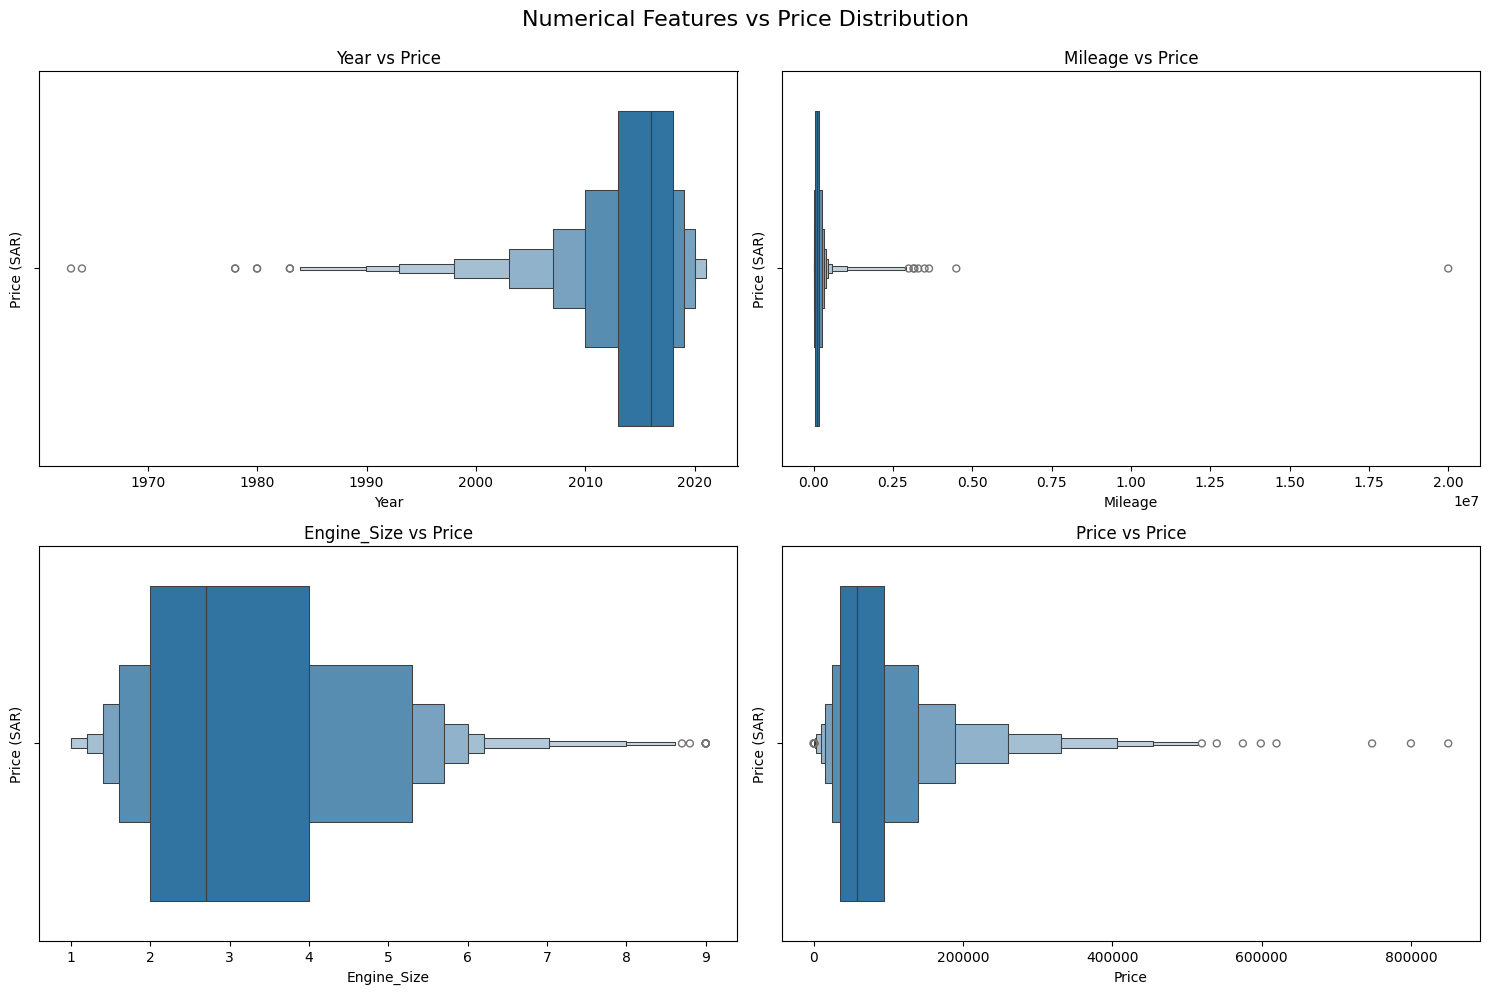

In [552]:
all_numerical_features = numerical_features + ['Price']

# create boxplot for numerical features
fig, axes = plt.subplots(2, 2, figsize=(15,  10))
fig.suptitle('Numerical Features vs Price Distribution', fontsize=16, y=0.99)

for idx, feature in enumerate(all_numerical_features):
    row = idx // 2
    col = idx % 2

    sns.boxenplot(data=df, x=feature, ax=axes[row, col])
    
    axes[row, col].set_title(f'{feature} vs Price')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Price (SAR)')

plt.tight_layout()
plt.show()


### Remove outliers

There is strange outlier in `Mileage` (top-right boxplot), the values seems odd `20.000.000` if we compare to other high mileage cars.

Let's drop this row for now, as it's too high even compared to other high mileage cars.


In [553]:
def remove_outliers(df, columns, n_std=3):
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[np.abs(df[col] - mean) <= (n_std * std)]
    
    return df

def remove_outliers_iqr(df, columns, k=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[
            (df_clean[col] >= Q1 - k * IQR) & 
            (df_clean[col] <= Q3 + k * IQR)
        ]
    return df_clean

# df = remove_outliers(df, numerical_features)
df_clean = remove_outliers_iqr(df, numerical_features)

df_clean.describe(include='all')
# df = df[df['Mileage'] < 20000000]
# df[df['Mileage'] > 1000000].sort_values(by='Mileage', ascending=False)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
count,3530,3530,3530,3530,3530,3530,3530.000000,3530.000000,3530.000000,3530,3530.000000
unique,309,27,55,2,4,3,NaN,NaN,NaN,1,NaN
top,Accent,Riyadh,Toyota,Automatic,Saudi,Full,NaN,NaN,NaN,False,NaN
freq,145,1524,792,3219,2695,1344,NaN,NaN,NaN,3530,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2015.796601,3.105156,115736.320963,NaN,81212.944193
std,NaN,NaN,NaN,NaN,NaN,NaN,3.241046,1.382896,89529.201686,NaN,73078.417447
min,NaN,NaN,NaN,NaN,NaN,NaN,2006.000000,1.000000,100.000000,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2014.000000,2.000000,48000.000000,NaN,38000.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2016.000000,2.700000,99000.000000,NaN,60000.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2018.000000,4.000000,169225.000000,NaN,98000.000000


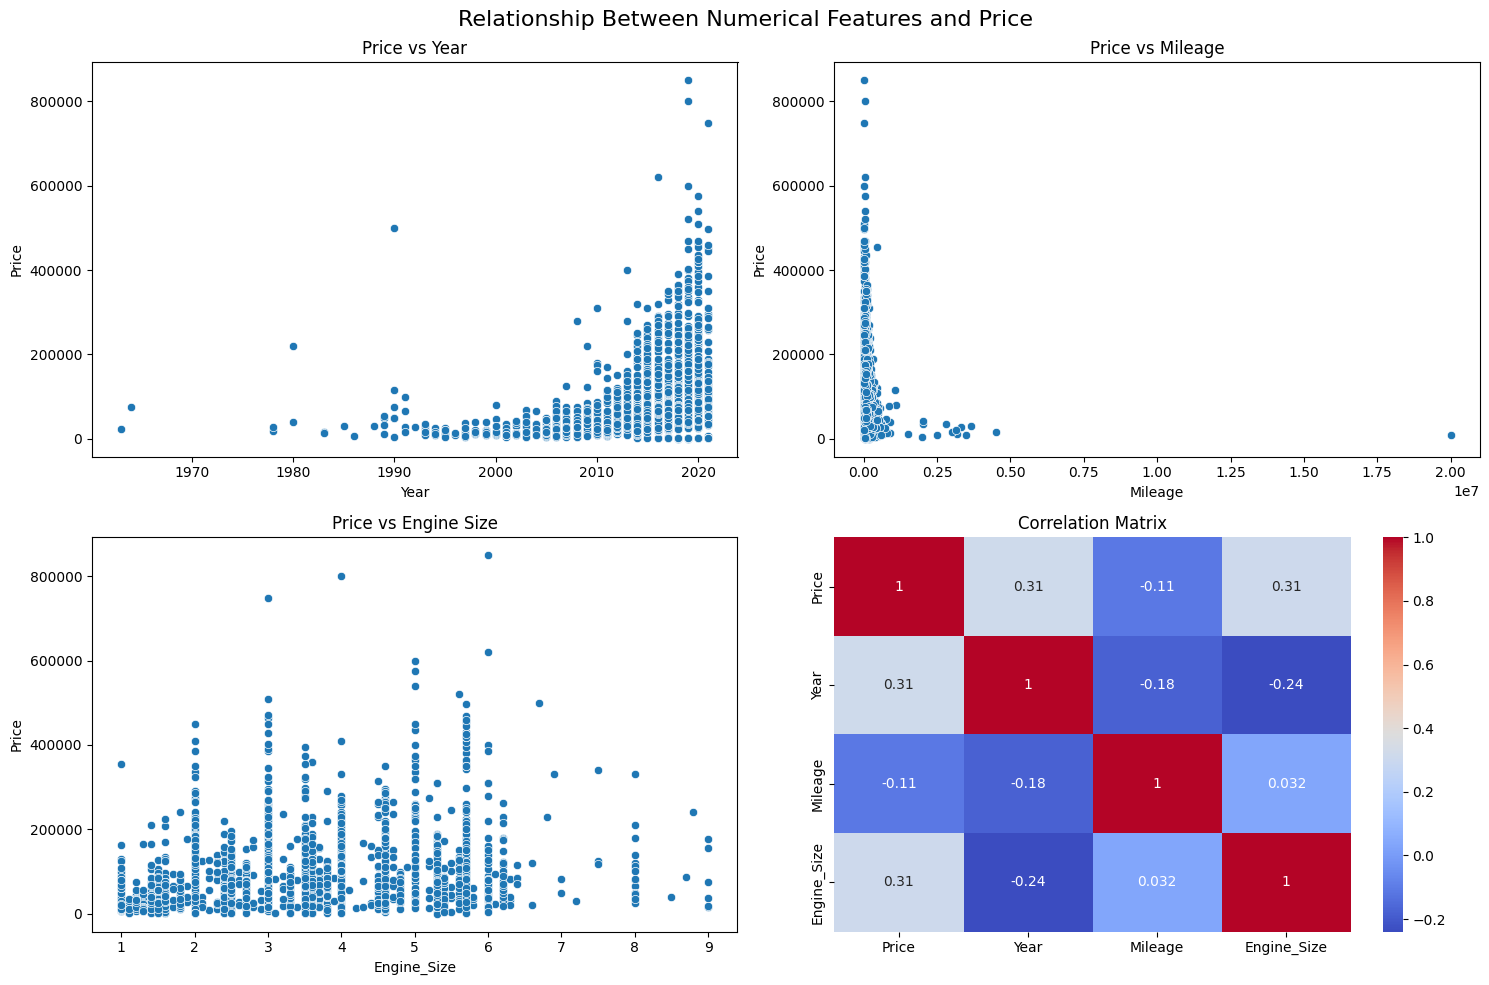


Correlation with Price:
Year: 0.314
Mileage: -0.113
Engine_Size: 0.308


In [554]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Relationship Between Numerical Features and Price', fontsize=16)

# Plot Price vs Year
sns.scatterplot(data=df[df['Price'] > 0], x='Year', y='Price', ax=axes[0,0])
axes[0,0].set_title('Price vs Year')

# Plot Price vs Mileage
sns.scatterplot(data=df[df['Price'] > 0], x='Mileage', y='Price', ax=axes[0,1])
axes[0,1].set_title('Price vs Mileage')

# Plot Price vs Engine_Size
sns.scatterplot(data=df[df['Price'] > 0], x='Engine_Size', y='Price', ax=axes[1,0])
axes[1,0].set_title('Price vs Engine Size')

# Calculate correlation
correlation_matrix = df[['Price', 'Year', 'Mileage', 'Engine_Size']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Print correlation values with Price
print("\nCorrelation with Price:")
for col in ['Year', 'Mileage', 'Engine_Size']:
    correlation = df[col].corr(df['Price'])
    print(f"{col}: {correlation:.3f}")

### Result

1. `Year vs Price`
    - Moderately negative correlation (0.31)
    - Almost linear with significant outliers (old cars and high price luxury cars)

2. `Mileage vs Price`
    - Negative weak correlation (-0.19)
    - Non linear

3. `Engine_Size vs Price`
    - Positive correlation (0.35)
    - Non linear correlation

Since both linear and non-linear correlation is present, we'll keep all of them, and to *assess* which model is the most suitable, together with categorical features.


## Categorical Features Correlation

Let's see the distribution of the price by each categorical feature.

### Boxplot distribution of price by each categorical feature

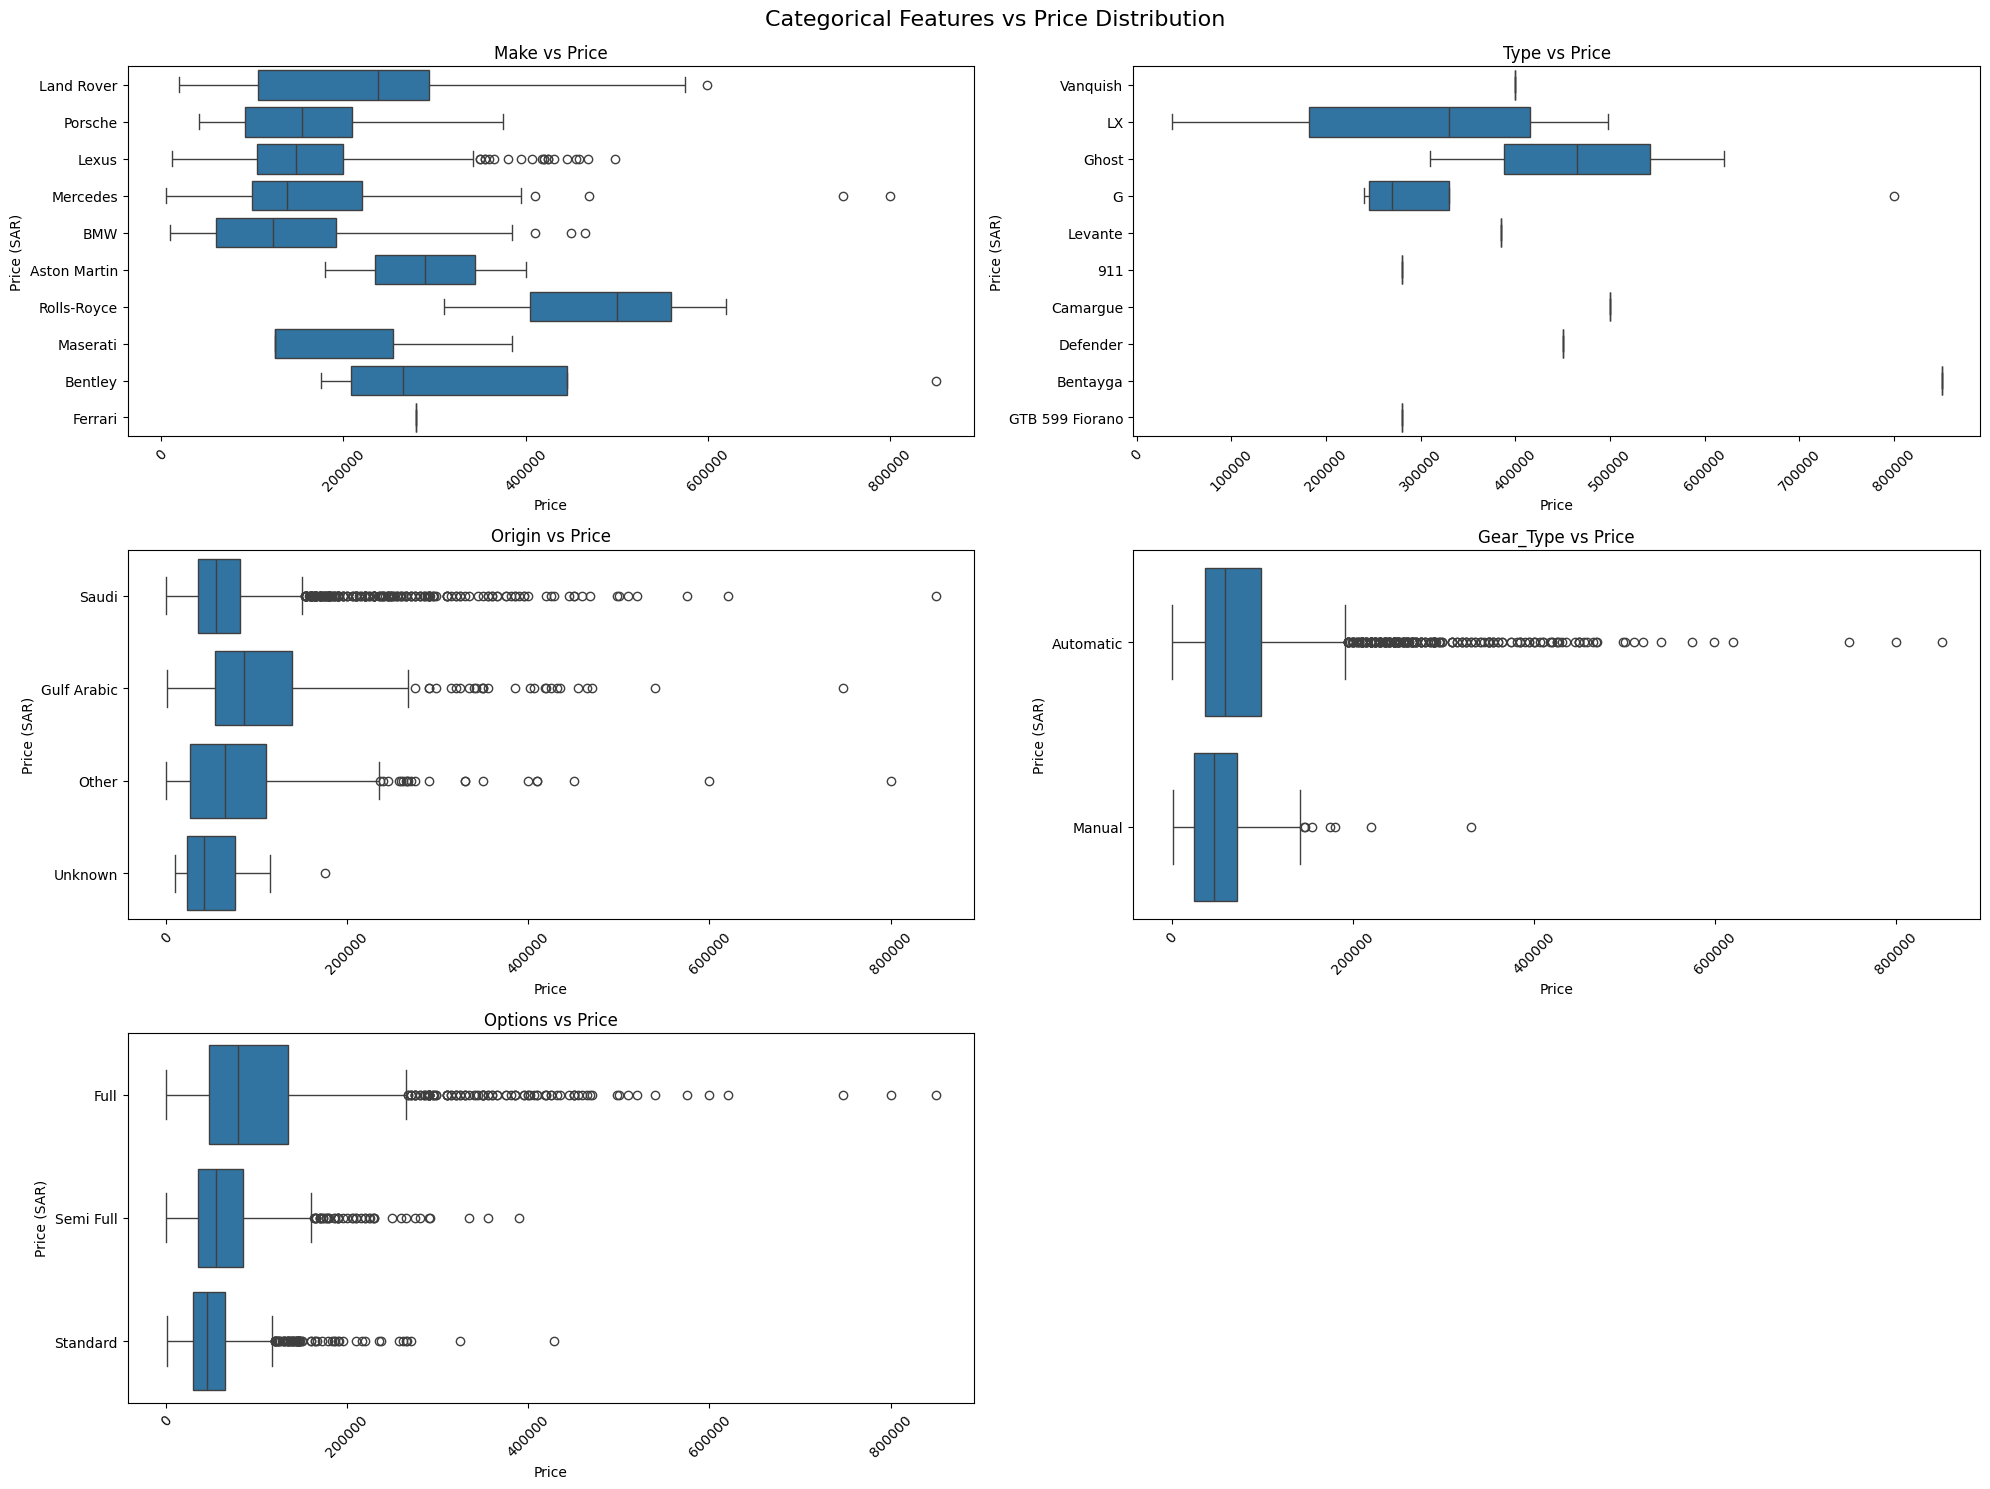

In [555]:
# Create boxplot for categorical features vs price
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Categorical Features vs Price Distribution', fontsize=16, y=0.99)

# Select top 4 categorical features based on their correlation
important_cats = ['Make', 'Type', 'Origin', 'Gear_Type', 'Options']

for idx, feature in enumerate(important_cats):
    row = idx // 2
    col = idx % 2
    
    if not (row == 2 and col == 1):
        # Calculate mean price for each category
        mean_prices = df.groupby(feature)['Price'].mean().sort_values(ascending=False).head(10)
        
        # Create bar plot
        sns.boxplot(data=df[df[feature].isin(mean_prices.index)], 
                    x='Price', y=feature,
                    ax=axes[row, col])
        
        axes[row, col].set_title(f'{feature} vs Price')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].set_ylabel('Price (SAR)')

axes[2, 1].set_visible(False)
plt.tight_layout()
plt.show()

## Data preprocessing

In [556]:
df_encoded = df.copy()
display(df_encoded)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
5,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
6,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000
...,...,...,...,...,...,...,...,...,...,...,...
5616,CX9,Qassim,Mazda,Automatic,Saudi,Full,2020,2.0,9500,False,132000
5618,Suburban,Riyadh,GMC,Automatic,Saudi,Full,2006,5.3,86000,False,50000
5619,X-Trail,Jeddah,Nissan,Automatic,Saudi,Standard,2018,2.5,78794,False,68000
5621,Yukon,Dammam,GMC,Automatic,Saudi,Full,2016,5.3,48000,False,145000


### Encode categorical variables

Based on observation, we have 3 types of categorical features:

1. Ordinal features: `Options` -> this is showing a car's interior features: `standard`, `semi-full` and `full`

2. Low cardinality features: `Gear_Type`, `Origin`

3. High cardinality features: `Type`, `Region`, `Make`


### Scaling numerical features

We'll use `StandardScaler` to scale the target variable, since it's important for encoding categorical features


Scaled numerical features statistics:
           Year   Mileage  Engine_Size
count  3824.000  3824.000     3824.000
mean      0.000    -0.000       -0.000
std       1.000     1.000        1.000
min     -10.147    -0.377       -1.495
25%      -0.362    -0.250       -0.810
50%       0.225    -0.105       -0.330
75%       0.616     0.107        0.561
max       1.203    52.485        3.989


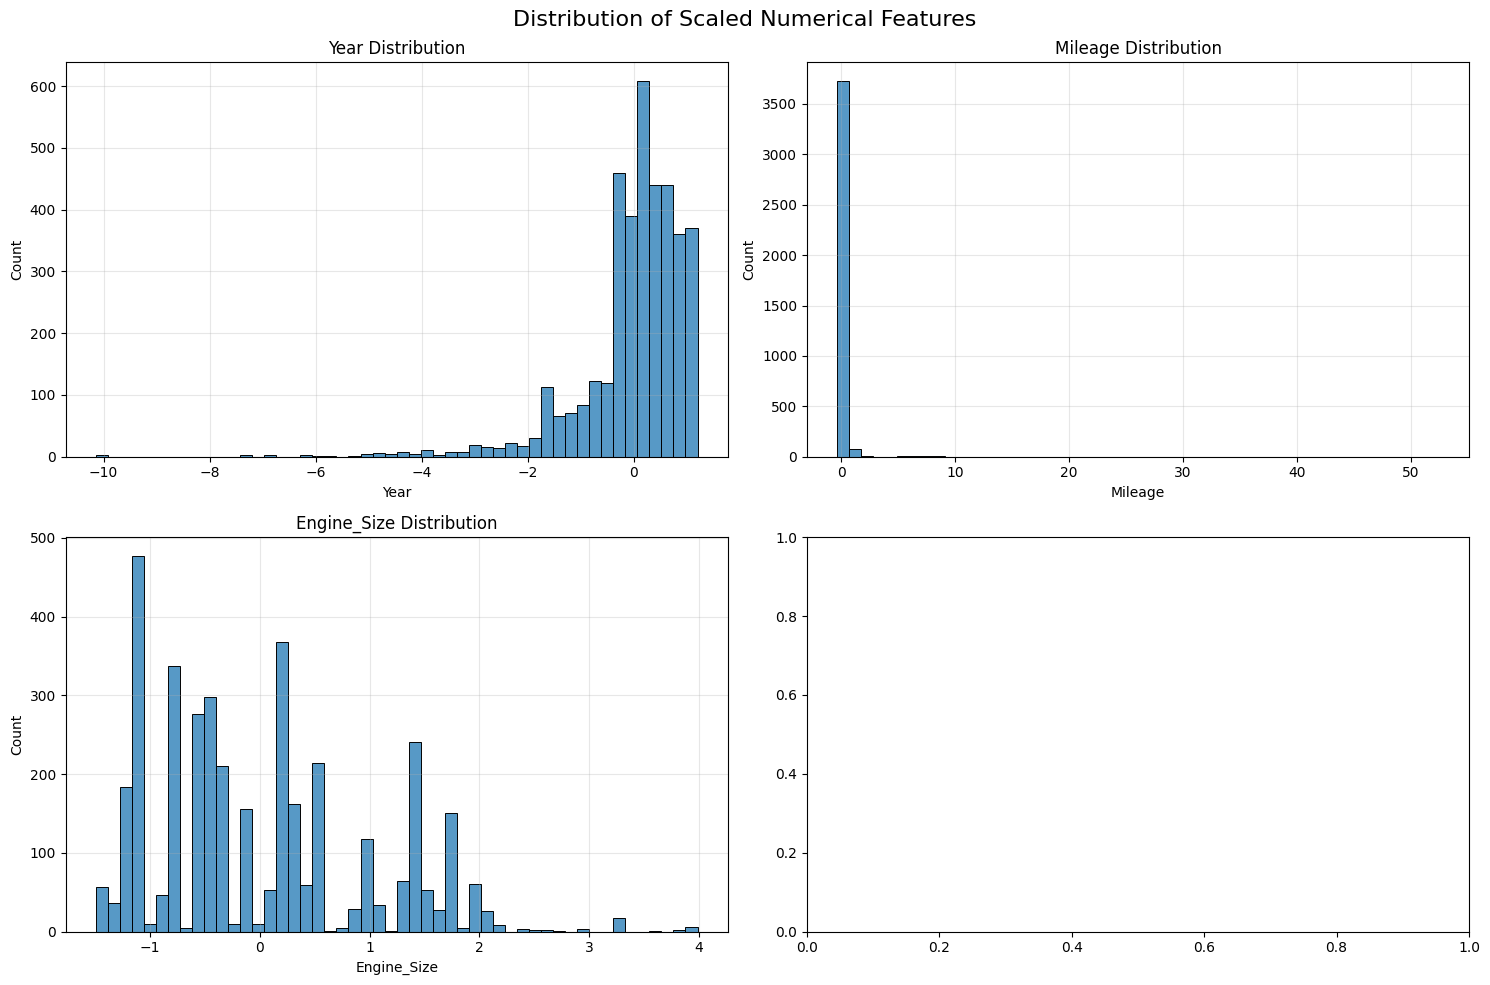

In [557]:
scaler = StandardScaler()
scaled_price = scaler.fit_transform(df[['Price']])

df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Verify the scaling
print("Scaled numerical features statistics:")
print(df_encoded[numerical_features].describe().round(3))

# Optional: Visualize the scaled distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Scaled Numerical Features', fontsize=16)

for idx, feature in enumerate(numerical_features):
    row = idx // 2
    col = idx % 2
    
    sns.histplot(data=df_encoded, x=feature, bins=50, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [558]:
# Handle categorical variables
ordinal_feature = 'Options'
low_cardinality_features = ['Gear_Type', 'Origin']
high_cardinality_features = ['Type', 'Region', 'Make']

# start the order from the lowest to the highest
options = ['Standard', 'Semi Full', 'Full']

encoders = {}
# Get one hot encoding for low cardinality features
df_encoded = pd.get_dummies(df_encoded, columns=low_cardinality_features, prefix=low_cardinality_features)

# Get ordinal encoding
ordinal = OrdinalEncoder(categories=[options])
df_encoded['Options'] = ordinal.fit_transform(df_encoded[[ordinal_feature]])

# Get target encoding for high cardinality features
for feature in high_cardinality_features:
    encoders[feature] = TargetEncoder()
    
    # Fit and transform on the same DataFrame
    df_encoded[feature] = encoders[feature].fit_transform(df[[feature]], scaled_price)


df_encoded

for feature in high_cardinality_features:
    print(f"\n{feature} encoding stats:")
    print(df_encoded[feature].describe())


Type encoding stats:
count    3824.000000
mean       -0.024231
std         0.649541
min        -1.050188
25%        -0.444053
50%        -0.184170
75%         0.157864
max         7.451068
Name: Type, dtype: float64

Region encoding stats:
count    3824.000000
mean       -0.000033
std         0.161728
min        -0.684193
25%        -0.079877
50%         0.043506
75%         0.055742
max         0.228193
Name: Region, dtype: float64

Make encoding stats:
count    3824.000000
mean       -0.011095
std         0.567191
min        -1.056140
25%        -0.343455
50%        -0.130536
75%         0.011802
max         5.801326
Name: Make, dtype: float64


### Visualize the encoded feature distribution

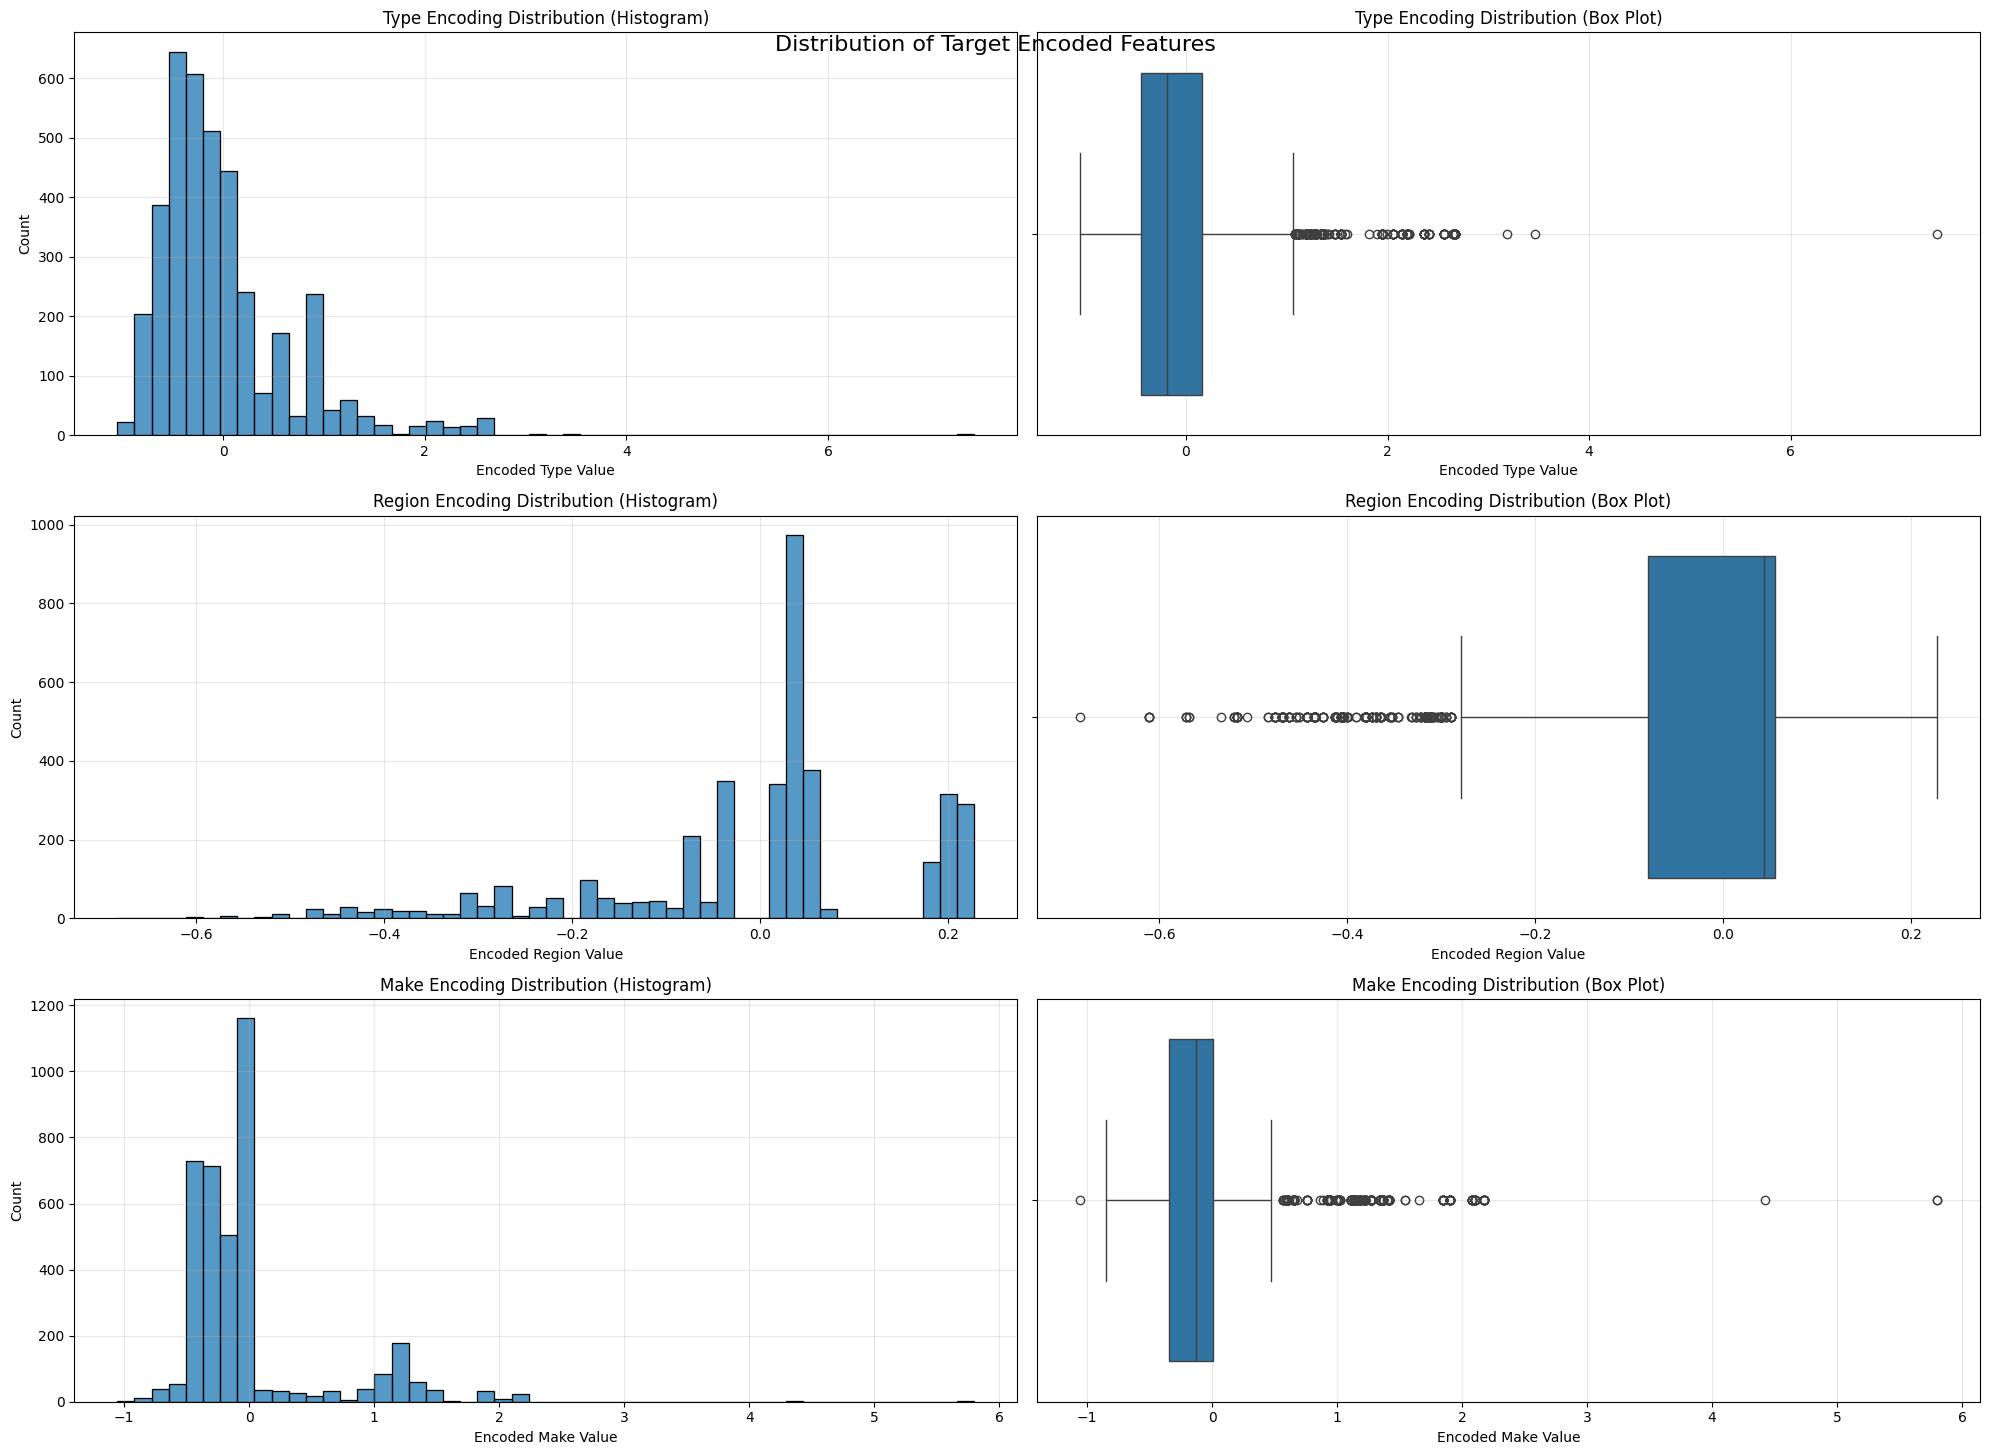


Type encoding stats:
count    3824.000
mean       -0.024
std         0.650
min        -1.050
25%        -0.444
50%        -0.184
75%         0.158
max         7.451
Name: Type, dtype: float64
Skewness: 1.978
Kurtosis: 7.555

Region encoding stats:
count    3824.000
mean       -0.000
std         0.162
min        -0.684
25%        -0.080
50%         0.044
75%         0.056
max         0.228
Name: Region, dtype: float64
Skewness: -0.983
Kurtosis: 1.049

Make encoding stats:
count    3824.000
mean       -0.011
std         0.567
min        -1.056
25%        -0.343
50%        -0.131
75%         0.012
max         5.801
Name: Make, dtype: float64
Skewness: 2.327
Kurtosis: 8.895


In [559]:
# Create distribution plots for encoded features
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Distribution of Target Encoded Features', fontsize=16, y=0.95)

# List of encoded features
encoded_features = ['Type', 'Region', 'Make']

for idx, feature in enumerate(encoded_features):
    # Histogram on the left
    sns.histplot(data=df_encoded, x=feature, bins=50, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{feature} Encoding Distribution (Histogram)')
    axes[idx, 0].set_xlabel(f'Encoded {feature} Value')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Box plot on the right
    sns.boxplot(data=df_encoded, x=feature, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{feature} Encoding Distribution (Box Plot)')
    axes[idx, 1].set_xlabel(f'Encoded {feature} Value')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for feature in encoded_features:
    print(f"\n{feature} encoding stats:")
    print(df_encoded[feature].describe().round(3))
    
    # Calculate additional statistics
    skewness = df_encoded[feature].skew()
    kurtosis = df_encoded[feature].kurtosis()
    print(f"Skewness: {skewness:.3f}")
    print(f"Kurtosis: {kurtosis:.3f}")

## Model Development and Analysis

We will test and evaluate 6 models to predict the price of the car:
- Linear Regression
- Ridge
- Lasso
- Random Forest
- XGBoost
- LightGBM


### Utility functions

In [560]:
'''
Calculate percentage errors with outlier handling

Making sure we don't divide by zero or very small values, and cap the extreme values at 100% error
'''
def calculate_pe(y_true, y_pred):
    pe = np.where(
        np.abs(y_true) > 1e-7,
        np.abs((y_true - y_pred) / y_true) * 100,
        0
    )
    pe = np.minimum(pe, 100)
    return pe

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model and measure time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'R2 Score (Train)': r2_score(y_train, y_pred_train),
        'R2 Score (Test)': r2_score(y_test, y_pred_test),
        'RMSE (Train)': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE (Test)': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'MAE (Train)': mean_absolute_error(y_train, y_pred_train),
        'MAE (Test)': mean_absolute_error(y_test, y_pred_test),
        'Training Time': training_time
    }
    
    # Calculate percentage error
    train_pe = np.abs((y_train - y_pred_train) / y_train) * 100
    test_pe = np.abs((y_test - y_pred_test) / y_test) * 100
    
    # Add percentage error metrics
    metrics.update({
        'Mean % Error (Train)': train_pe.mean(),
        'Mean % Error (Test)': test_pe.mean(),
        'Median % Error (Train)': train_pe.median(),
        'Median % Error (Test)': test_pe.median(),
        '% Predictions within 20% error (Train)': (train_pe <= 20).mean() * 100,
        '% Predictions within 20% error (Test)': (test_pe <= 20).mean() * 100
    })
    
    return metrics

def plot_model_accuracy(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Model Accuracy Comparison', fontsize=16)
    
    # Plot % Predictions within 20%
    sns.barplot(data=results_df, x=results_df.index, y='% Predictions within 20% error (Test)', 
                ax=axes[0,0], palette='viridis')
    axes[0,0].set_title('% Predictions within 20% error (Test Set)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot Median % Error
    sns.barplot(data=results_df, x=results_df.index, y='Median % Error (Test)', 
                ax=axes[0,1], palette='viridis')
    axes[0,1].set_title('Median % Error (Test Set)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot R2 Train vs Test
    r2_data = pd.DataFrame({
        'Model': np.repeat(results_df.index.values, 2),
        'Metric': ['Train', 'Test'] * len(results_df),
        'Value': np.concatenate([
            results_df['R2 Score (Train)'].values,
            results_df['R2 Score (Test)'].values
        ])
    })
    sns.barplot(data=r2_data, x='Model', y='Value', hue='Metric', ax=axes[1,0])
    axes[1,0].set_title('R² Score: Train vs Test')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Plot RMSE Train vs Test
    rmse_data = pd.DataFrame({
        'Model': np.repeat(results_df.index.values, 2),
        'Metric': ['Train', 'Test'] * len(results_df),
        'Value': np.concatenate([
            results_df['RMSE (Train)'].values,
            results_df['RMSE (Test)'].values
        ])
    })
    sns.barplot(data=rmse_data, x='Model', y='Value', hue='Metric', ax=axes[1,1])
    axes[1,1].set_title('RMSE: Train vs Test')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


## Model Development and Evaluation

We skip scaling the independent variables / features because it's already scaled in the preprocessing step.

However, we don't scale the *target variable* / `Price`, since it's important for encoding categorical features.


In [561]:
# 1. Prepare features and target
X = df_encoded.drop(['Price'], axis=1)
y = df_encoded['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set: ")
display(pd.concat([X_train, y_train], axis=1))

# 2. Create and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Evaluate all models
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

# 3. Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Display results
print("\nModel Comparison:")
display(results_df)

Training set: 


,Type,Region,Make,Options,Year,Engine_Size,Mileage,Negotiable,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Price
559,0.067478,-0.080020,-0.013370,0.0,-0.753624,-0.329841,0.426539,False,True,False,False,False,True,False,32000
4604,-0.079187,0.055742,0.001222,1.0,0.616173,-0.329841,-0.177843,False,False,True,False,False,True,False,78000
4905,0.072195,0.043620,0.033947,1.0,0.029117,0.561400,0.164873,False,True,False,False,False,True,False,61000
1225,-0.137743,-0.080020,0.323592,2.0,0.224803,-1.221081,-0.221018,False,True,False,False,False,True,False,70000
1033,0.082293,0.192499,0.013055,0.0,0.616173,1.452640,0.142671,False,True,False,False,False,True,False,130000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,-0.115315,0.044100,0.033947,1.0,0.616173,-0.329841,-0.097961,False,False,True,False,False,True,False,76500
1916,-0.094670,0.055742,0.011802,2.0,0.224803,-0.329841,0.468829,False,False,True,False,False,True,False,65000
1271,-0.520251,-0.035904,-0.411712,0.0,0.224803,-0.466955,-0.247449,False,True,False,False,False,True,False,49000
5178,-0.743751,0.043620,-0.704850,1.0,0.029117,-1.083967,-0.028073,False,True,False,False,False,True,False,23000



Evaluating Linear Regression...

Evaluating Ridge...

Evaluating Lasso...

Evaluating Random Forest...

Evaluating XGBoost...

Evaluating LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833
[LightGBM] [Info] Number of data points in the train set: 3059, number of used features: 12
[LightGBM] [Info] Start training from score 78323.753514

Model Comparison:


,R2 Score (Train),R2 Score (Test),RMSE (Train),RMSE (Test),MAE (Train),MAE (Test),Training Time,Mean % Error (Train),Mean % Error (Test),Median % Error (Train),Median % Error (Test),% Predictions within 20% error (Train),% Predictions within 20% error (Test)
Linear Regression,0.5995,0.5839,45631.8905,48505.2022,25129.8898,26138.0248,0.0014,4028.7283,157.2172,22.7671,22.8482,45.8974,44.0523
Ridge,0.5995,0.5839,45631.9276,48506.5157,25123.9242,26133.3764,0.0011,4033.2862,157.2928,22.7306,22.7661,45.9627,43.9216
Lasso,0.5995,0.5840,45631.8937,48503.8921,25128.4890,26136.8329,0.0164,4029.2707,157.2294,22.7718,22.8037,45.8974,44.0523
Random Forest,0.9710,0.8473,12281.0052,29384.0642,5883.5058,15509.7903,0.7188,1256.7214,121.9272,4.7812,14.6784,90.0948,62.4837
XGBoost,0.9916,0.8689,6589.7618,27229.9544,4487.7806,14865.8845,0.1379,166.6476,111.1005,5.1458,13.9194,91.8928,63.2680
LightGBM,0.9301,0.8703,19061.1609,27081.3719,10573.5719,15295.0097,0.4409,2391.5187,117.6473,10.4747,14.3575,75.5476,62.8758


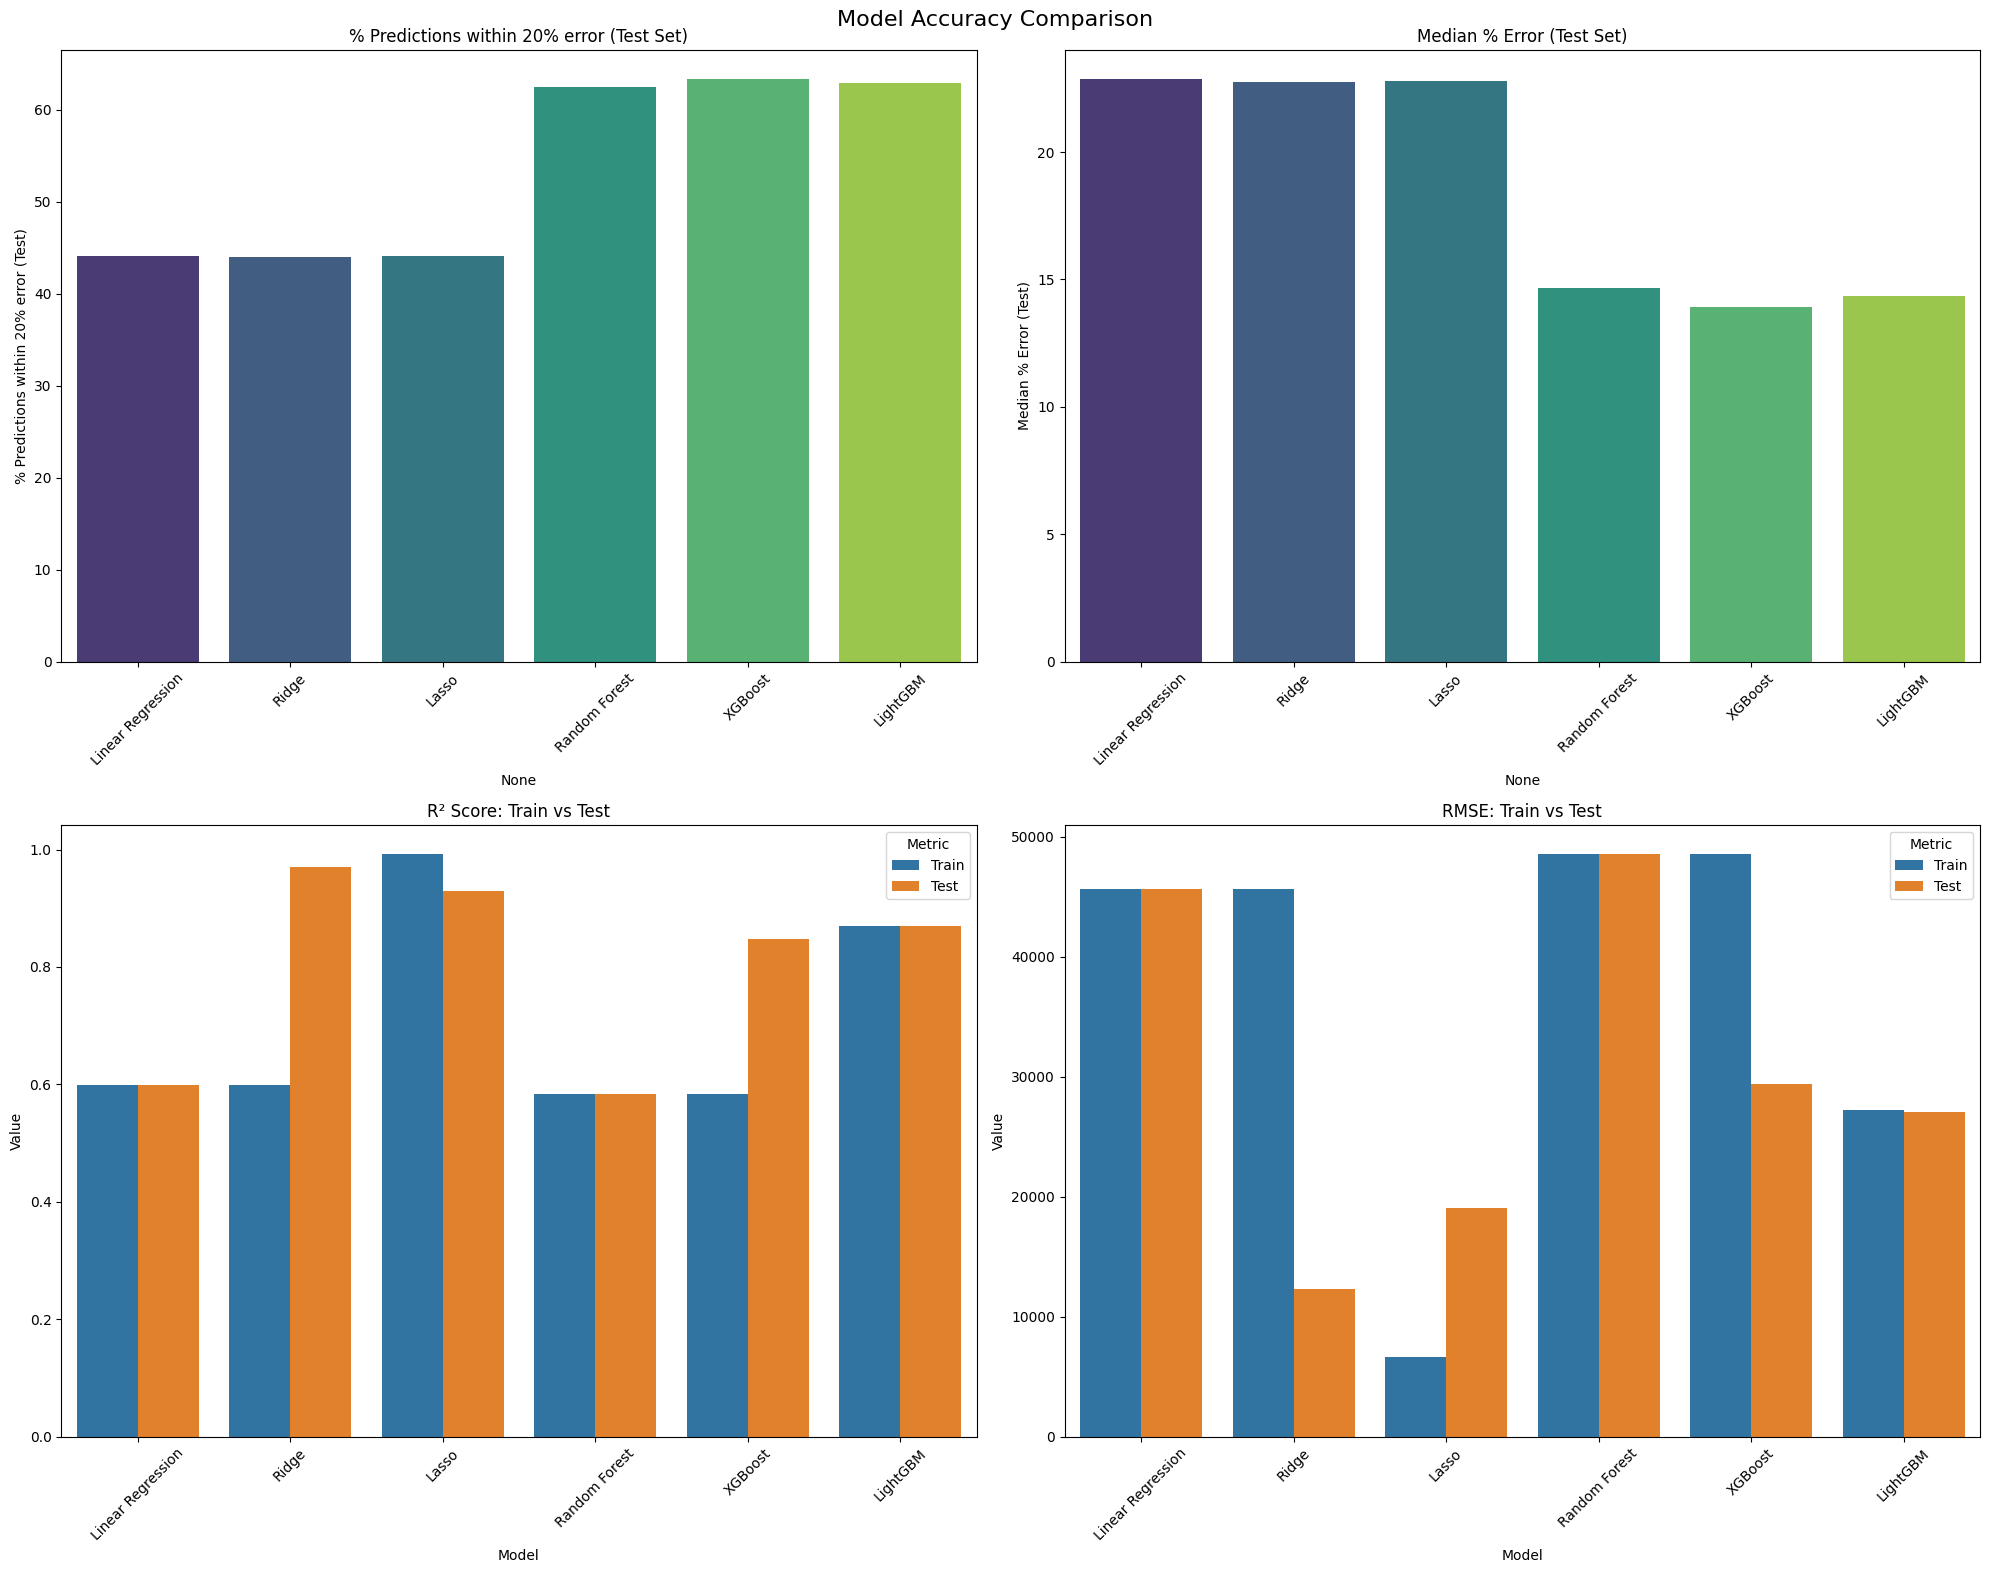

In [562]:
plot_model_accuracy(results_df)

## Results

From the results, we can see that the `XGBoost` model has the best performance:
1. Highest R² score -> means it explains the variance of the price the highest, i.e. 83%
2. Lowest RMSE (lower is better)
3. Lowest MAE (lower is better)
4. Fastest training time

We'll choose the `XGBoost` as our final model, since it has a good balance between performance and training time.

## Option 2: Pipeline and Cross Validation

Let's try to improve the model by using pipeline and cross validation, to have consistent and better model performance and evaluation.

In [568]:
# 1. First remove outliers
df_clean = remove_outliers_iqr(raw_df, numerical_features)

# to show the order of each options
options = ['Standard', 'Semi Full', 'Full']

# 2. Create feature groups for the pipeline
numeric_features = ['Year', 'Mileage', 'Engine_Size']
ordinal_feature = ['Options']
target_encoder_features = ['Origin', 'Gear_Type', 'Make', 'Type', 'Region']

# 3. Create preprocessing pipeline with your existing scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories=[options]))
])

target_encoder_transformer = Pipeline(steps=[
    ('target_encoder', TargetEncoder())
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_feature),
        ('cat', target_encoder_transformer, target_encoder_features)
    ],
    remainder='drop'
)

# 4. Create and train the model pipeline with improved hyperparameters
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    ))
])

# 5. Prepare data (same as before)
X_clean = df_clean.drop('Price', axis=1)
y_clean = df_clean['Price']

# 6. Enhanced cross-validation with multiple metrics
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Define scoring metrics
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'mape': make_scorer(mean_absolute_percentage_error)
}
kfold = 5

# Perform cross validation with multiple metrics
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    model_pipeline,
    X_clean,
    y_clean,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1  # Use all available CPU cores
)

# Print detailed cross-validation results
print("\nCross-validation results:")
for metric in scoring.keys():
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    # Handle negative scores for RMSE and MAE
    if metric in ['rmse', 'mae']:
        train_scores = -train_scores
        test_scores = -test_scores
    
    print(f"\n{metric.upper()}:")
    print(f"Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print(f"Test:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

# 7. Final model training and evaluation
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# Train the model (removed early stopping parameters)
model_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

# Calculate and print comprehensive metrics
def print_metrics(y_true, y_pred, dataset_name=""):
    print(f"\n{dataset_name} Metrics:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    
    # Calculate percentage of predictions within different error margins
    for margin in [10, 20, 30]:
        within_margin = np.mean(np.abs((y_true - y_pred) / y_true) <= margin/100) * 100
        print(f"Within {margin}% margin: {within_margin:.2f}%")

print_metrics(y_train, y_pred_train, "Training")
print_metrics(y_test, y_pred_test, "Test")

# Plot feature importance
if hasattr(model_pipeline.named_steps['regressor'], 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': model_pipeline.named_steps['preprocessor'].get_feature_names_out(),
        'importance': model_pipeline.named_steps['regressor'].feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/andresuchitra/dev/saudi-used-cars/.venv/lib/python3.12/site-packages/sklearn/model_se


Cross-validation results:

RMSE:
Train: 24459.3377 (+/- 2261.0966)
Test:  31990.9326 (+/- 10368.6845)

R2:
Train: 0.8873 (+/- 0.0245)
Test:  0.8048 (+/- 0.0716)

MAE:
Train: 11308.3084 (+/- 438.9823)
Test:  15284.6572 (+/- 2282.4159)

MAPE:
Train: 28.0621 (+/- 30.6205)
Test:  53.2839 (+/- 208.9645)

Training Metrics:
R² Score: 0.9011
RMSE: 23485.6242
MAE: 11364.2813
MAPE: 19.5853
Within 10% margin: 51.35%
Within 20% margin: 77.48%
Within 30% margin: 88.24%

Test Metrics:
R² Score: 0.8676
RMSE: 24085.3559
MAE: 13756.3122
MAPE: 0.6969
Within 10% margin: 42.78%
Within 20% margin: 69.97%
Within 30% margin: 82.86%

Top 10 Most Important Features:
               feature  importance
1195  cat__Make_170000    0.140494
1263  cat__Make_290000    0.101100
1227  cat__Make_220000    0.084908
1607  cat__Type_150000    0.043067
1349    cat__Type_2000    0.027573
1711  cat__Type_350000    0.021810
1677  cat__Type_245000    0.016661
1705  cat__Type_325000    0.010567
1662  cat__Type_220000    0.010201